In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf
from tensorflow.python.keras import backend as K

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import time

# MSE Imports
import kepler_sieve
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, perturb_elts, random_elts, elts_add_mixture_params
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel, make_opt_adam
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

Found 4 GPUs.  Setting memory growth = True.


In [2]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [3]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Load ZTF Data and Batch of Orbital Elements

In [4]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [5]:
# Load ztf nearest asteroid data
ztf_ast = load_ztf_nearest_ast()

In [6]:
# Asteroid numbers and hit counts
ast_num, hit_count = calc_hit_freq(ztf=ztf_ast, thresh_sec=2.0)

# Sort the hit counts in descending order and find the top batch_size
idx = np.argsort(hit_count)[::-1]

# Extract the asteroid number and hit count for this batch
ast_num_best = ast_num[idx]
hit_count_best = hit_count[idx]

In [7]:
# Parameters to build elements batch
batch_size = 64

# Batch of unperturbed elements
elts_ast = asteroid_elts(ast_nums=ast_num_best[0:batch_size])

In [8]:
# # Review unperturbed elements
# elts_ast

In [9]:
# Inputs to perturb elements: large
sigma_a = 0.05
sigma_e = 0.01
sigma_inc_deg = 0.25
sigma_f_deg = 1.0
sigma_Omega_deg = 1.0
sigma_omega_deg = 1.0
mask_pert = None
random_seed = 42

# Perturb orbital elements
elts_pert= perturb_elts(elts_ast, sigma_a=sigma_a, sigma_e=sigma_e, 
                    sigma_inc_deg=sigma_inc_deg, sigma_f_deg=sigma_f_deg, 
                    sigma_Omega_deg=sigma_Omega_deg, sigma_omega_deg=sigma_omega_deg,
                    mask_pert=mask_pert, random_seed=random_seed)

In [10]:
# Choose which elements to search on
elts = elts_pert

In [11]:
# Search for nearest asteroids to these elements
# elts_near = nearest_ast_elt(elts)

In [12]:
# Review selected initial candidate elements, including the nearest asteroid information
# elts

In [13]:
# Review nearest asteroid to these candidate elements
# elts_near

In [14]:
# How many elements are still closest to the original elements?
# np.sum(elts.nearest_ast_num == elts.element_id)

## Batches of ZTF Data Near Initial Candidate Elements

In [15]:
# Arguments to make_ztf_batch
thresh_deg = 2.0
near_ast = False
regenerate = False

In [16]:
elts

,element_id,a,e,inc,Omega,omega,f,epoch
0,51921,2.736430,0.219134,0.499988,4.721815,2.452489,-1.129754,58600.0
1,59244,2.616575,0.266087,0.462848,5.725946,1.777382,-1.623105,58600.0
2,15786,1.945213,0.047621,0.385594,6.142435,0.790543,-1.243047,58600.0
3,3904,2.758664,0.099270,0.261841,5.463683,2.238942,-1.350620,58600.0
4,142999,2.589450,0.192070,0.509382,0.221844,0.928905,-1.314727,58600.0
...,...,...,...,...,...,...,...,...
59,11952,2.330603,0.084892,0.117649,0.042808,2.890716,-3.000560,58600.0
60,134815,2.550916,0.141660,0.510228,0.284591,0.630896,-0.920797,58600.0
61,27860,2.595202,0.098315,0.194023,5.535984,3.255585,3.966790,58600.0
62,85937,2.216242,0.195323,0.437115,5.285351,3.172956,3.921169,58600.0


In [17]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [18]:
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,...,vz,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit
0,306,733,b'ZTF18abiyevm',567274570115015018,3341,58321.274572,275.834958,-12.178240,0.099376,-0.976101,...,0.004095,0.080910,-0.982320,0.168822,2.050675,0.031258,6447.753750,0.999511,0.801975,False
1,6391,733,b'ZTF18ablpbwh',617122522515015016,8730,58371.122523,272.156750,-10.136454,0.037046,-0.972528,...,0.003837,0.016116,-0.975703,0.218503,2.491969,0.024005,4951.468379,0.999712,0.472962,False
2,6392,733,b'ZTF18ablpbwh',618126362515015025,8913,58372.126366,272.156760,-10.136446,0.037046,-0.972528,...,0.003830,0.017464,-0.975564,0.219021,2.503645,0.022568,4655.153797,0.999745,0.418050,False
3,6393,733,b'ZTF18ablpbwh',611146562515015015,7585,58365.146562,272.156733,-10.136444,0.037046,-0.972528,...,0.003876,0.010155,-0.976524,0.215169,2.423439,0.030883,6370.298847,0.999523,0.782824,False
4,12249,733,b'ZTF18ablwzcc',584190354815015015,4647,58338.190359,273.272132,-13.497675,0.055502,-0.983530,...,0.004023,0.030085,-0.980846,0.192450,2.155818,0.032724,6750.065879,0.999465,0.878934,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290766,5650772,324582,b'ZTF20aaqvhnd',1150176700415015000,96618,58904.176701,48.664349,31.318054,0.564235,0.795279,...,-0.001786,0.584015,0.786561,0.200621,2.748814,0.030221,6233.797319,0.999543,0.749638,False
290767,5650773,324582,b'ZTF20aaqvhns',1150176245615015007,96617,58904.176250,45.820577,29.378228,0.607285,0.768505,...,-0.001786,0.584016,0.786559,0.200622,2.748808,0.029465,6077.915470,0.999566,0.712618,False
290768,5650789,324582,b'ZTF20aaqvhnm',1150176245015015006,96617,58904.176250,48.881586,28.300138,0.579016,0.797156,...,-0.001786,0.584016,0.786559,0.200622,2.748808,0.031743,6547.783696,0.999496,0.827049,False
290769,5650791,324582,b'ZTF20aaqvhog',1150176244815015007,96617,58904.176250,49.429756,29.370649,0.566783,0.802441,...,-0.001786,0.584016,0.786559,0.200622,2.748808,0.027275,5625.990260,0.999628,0.610591,False


In [19]:
# Score by element - perturbed
score_by_elt = ztf_score_by_elt(ztf_elt)

In [20]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Perturbed Asteroids')

ZTF Element Dataframe Perturbed Asteroids:
                  Total     (Per Batch)
Observations   :   290771   (     4543)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :      42.77
Sqrt(batch_obs):      67.40
Mean t_score   :       0.58


In [46]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [47]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, R_deg=R_deg, thresh_deg=thresh_deg)

In [48]:
# Review perturbed elements; includes nearest asteroid number and distance
elts

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,thresh_s
0,51921,2.736430,0.219134,0.499988,4.721815,2.452489,-1.129754,58600.0,10,0.008727,0.034905
1,59244,2.616575,0.266087,0.462848,5.725946,1.777382,-1.623105,58600.0,10,0.008727,0.034905
2,15786,1.945213,0.047621,0.385594,6.142435,0.790543,-1.243047,58600.0,10,0.008727,0.034905
3,3904,2.758664,0.099270,0.261841,5.463683,2.238942,-1.350620,58600.0,10,0.008727,0.034905
4,142999,2.589450,0.192070,0.509382,0.221844,0.928905,-1.314727,58600.0,10,0.008727,0.034905
...,...,...,...,...,...,...,...,...,...,...,...
59,11952,2.330603,0.084892,0.117649,0.042808,2.890716,-3.000560,58600.0,10,0.008727,0.034905
60,134815,2.550916,0.141660,0.510228,0.284591,0.630896,-0.920797,58600.0,10,0.008727,0.034905
61,27860,2.595202,0.098315,0.194023,5.535984,3.255585,3.966790,58600.0,10,0.008727,0.034905
62,85937,2.216242,0.195323,0.437115,5.285351,3.172956,3.921169,58600.0,10,0.008727,0.034905


## Train on Perturbed Elements: Learn Mixture Parameters

In [60]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [61]:
# Training parameters
learning_rate = 2.0**-15
clipnorm = 1.0
save_at_end: bool = True

In [62]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                name='model')

In [63]:
# Report before training starts
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec : thresh_deg
Mean :     0.08  :   0.00 :  0.500000 :  1800.00 : 2.000000
Std  :     0.88  :   0.00 :  0.000000 :     0.00 : 0.000000
Min  :    -1.16  :   0.00 :  0.500000 :  1800.00 : 2.000000
Max  :     3.47  :   0.00 :  0.500000 :  1800.00 : 2.000000
Trained for 0 batches over 0 epochs and 0 episodes.


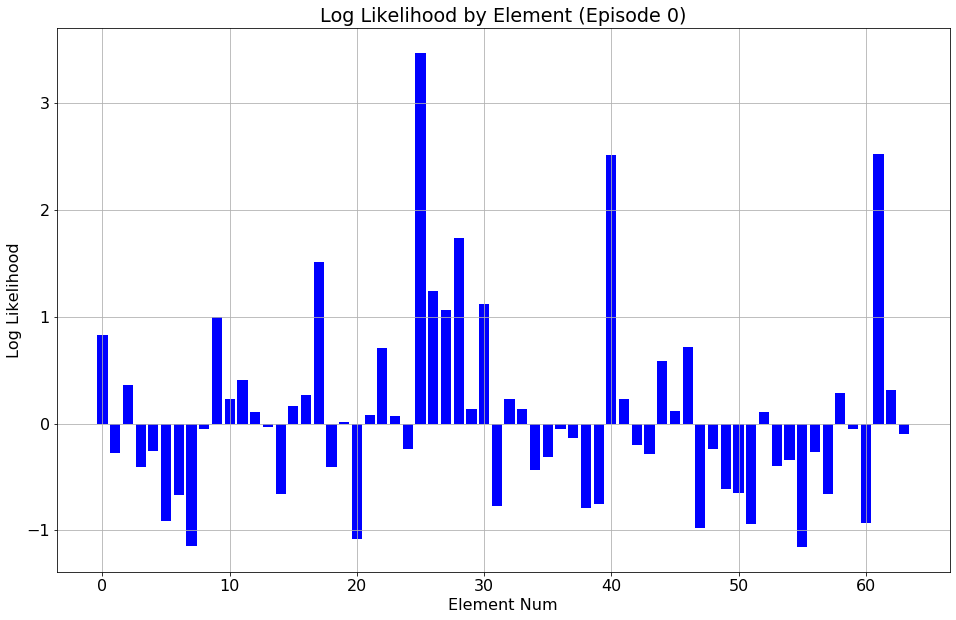

In [64]:
# Visualize log likelihood before traning
fig, ax = model.plot_bar('log_like', sorted=False)

In [65]:
# Adaptive search parameters
max_batches_mixture = 2000
max_batches_element = 10000
batches_per_epoch = 100
epochs_per_episode = 5
max_bad_episodes = 3
min_learning_rate = None
save_at_end = False
reset_active_weight = False
verbose = 1

In [66]:
# # Load model
# model.load()
# model.report()

In [67]:
# Preliminary round of training with frozen elements
model.freeze_candidate_elements()

In [68]:
# Train perturbed model with frozen orbital elements
model.search_adaptive(
    max_batches=1000, 
    learning_rate=2.0**-12,
)


Training episode 0: Epoch    0, Batch      0
effective_learning_rate=3.052e-05, training_time 0 sec.
Train on 6400 samples
Epoch 1/5
6400/6400 [==============================] - 4s 634us/sample - loss: -64.3893
Epoch 2/5
6400/6400 [==============================] - 2s 299us/sample - loss: -67.7728
Epoch 3/5
6400/6400 [==============================] - 2s 294us/sample - loss: -71.2931
Epoch 4/5
6400/6400 [==============================] - 2s 294us/sample - loss: -74.9577
Epoch 5/5
6400/6400 [==============================] - 2s 298us/sample - loss: -78.7723
Adjusted element weight down on 20 candidate elements. Mean weight = 8.44e-01
Geom Mean Resolution: 0.484900 degrees (1745.6 arc seconds)
Mean Hits          :      0.00
Mean Log Likelihood:      0.23

Training episode 1: Epoch    5, Batch    500
effective_learning_rate=2.060e-04, training_time 20 sec.
Train on 6400 samples
Epoch 6/10
6400/6400 [==============================] - 2s 302us/sample - loss: -73.0446
Epoch 7/10
6400/6400 [

In [71]:
# mp = model.mixture_parameters
# mp.get_num_hits()

In [69]:
# Report after initial training on mixture parameters
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec : thresh_deg
Mean :     0.40  :   0.00 :  0.476854 :  1716.67 : 2.000000
Std  :     1.27  :   0.00 :  0.095836 :   345.01 : 0.000000
Min  :    -0.81  :   0.00 :  0.375980 :  1353.53 : 2.000000
Max  :     5.97  :   0.00 :  0.711053 :  2559.79 : 2.000000
Trained for 1000 batches over 10 epochs and 2 episodes.


In [72]:
model.save_state()

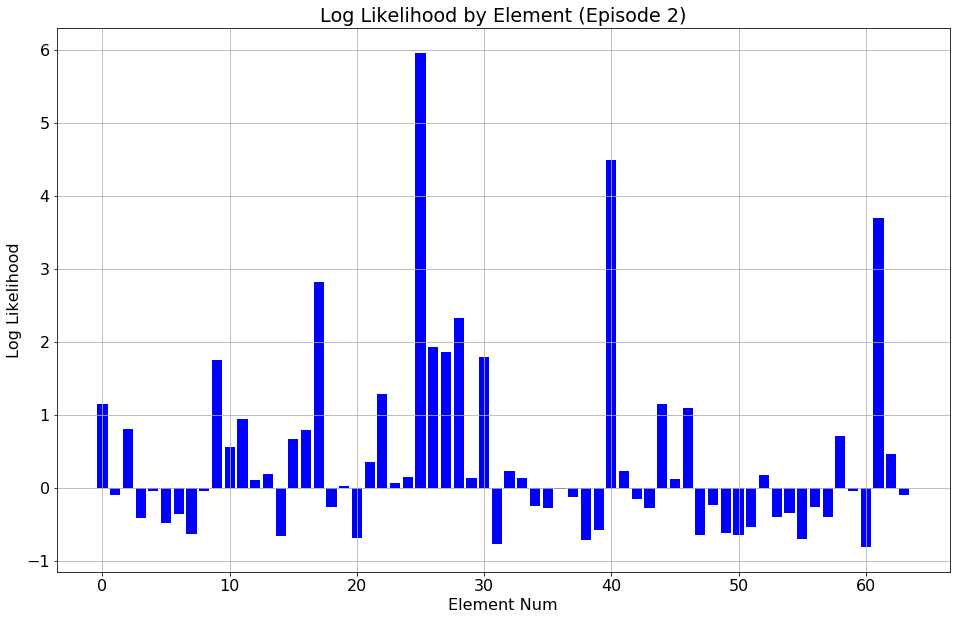

In [73]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=False)

In [ ]:
# # Bar chart - hits by element
# fig, ax = model.plot_bar('hits', sorted=False)

In [ ]:
# # Bar chart - resolution by element
# fig, ax = model.plot_bar('R_deg', sorted=False)

## Train on Perturbed Model: Joint (Elements & Mixture)

In [74]:
model.load()

In [75]:
# Unfreeze the elements
model.thaw_candidate_elements()
model.thaw_mixture_parameters()
# model.thaw_score()

In [76]:
# Length of training
max_batches_element = 2000

# thresh_deg at end: don't use, score layer is thawed
thresh_deg_end = None

# New smaller learning rate
learning_rate = 2.0**-15

# Reset active weight
reset_active_weight = True

In [77]:
# Train model in joint mode
model.search_adaptive(max_batches=2000)


Training episode 2: Epoch   10, Batch   1000
effective_learning_rate=1.831e-04, training_time 30 sec.
Train on 6400 samples
Epoch 11/15
6400/6400 [==============================] - 4s 645us/sample - loss: -437.0386
Epoch 12/15
6400/6400 [==============================] - 2s 390us/sample - loss: -562.4117
Epoch 13/15
6400/6400 [==============================] - 2s 385us/sample - loss: -648.3623
Epoch 14/15
6400/6400 [==============================] - 2s 382us/sample - loss: -723.5465
Epoch 15/15
6400/6400 [==============================] - 2s 387us/sample - loss: -795.5938
Geom Mean Resolution: 0.344211 degrees (1239.2 arc seconds)
Mean Hits          :      0.00
Mean Log Likelihood:     10.56

Training episode 3: Epoch   15, Batch   1500
effective_learning_rate=1.831e-04, training_time 89 sec.
Train on 6400 samples
Epoch 16/20
6400/6400 [==============================] - 2s 389us/sample - loss: -871.9339
Epoch 17/20
6400/6400 [==============================] - 3s 391us/sample - loss: -

In [78]:
# Report after training
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec : thresh_deg
Mean :    15.59  :   0.00 :  0.288950 :  1040.22 : 2.000000
Std  :     8.60  :   0.00 :  0.058985 :   212.34 : 0.000000
Min  :     3.25  :   0.00 :  0.216705 :   780.14 : 2.000000
Max  :    54.70  :   0.00 :  0.433540 :  1560.74 : 2.000000
Trained for 2000 batches over 20 epochs and 4 episodes.


In [ ]:
model.save_state()

In [ ]:
model.load()

In [ ]:
model.set_thresh_deg_max(1.75)
model.set_R_deg_max(1.75/4.0)
model.save_weights()

In [ ]:
model.report()

In [ ]:
# Train model in joint mode
model.search_adaptive(
    max_batches=3000, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    thresh_deg_end=thresh_deg_end,
    learning_rate=learning_rate,
    reset_active_weight=reset_active_weight,
    verbose=verbose)

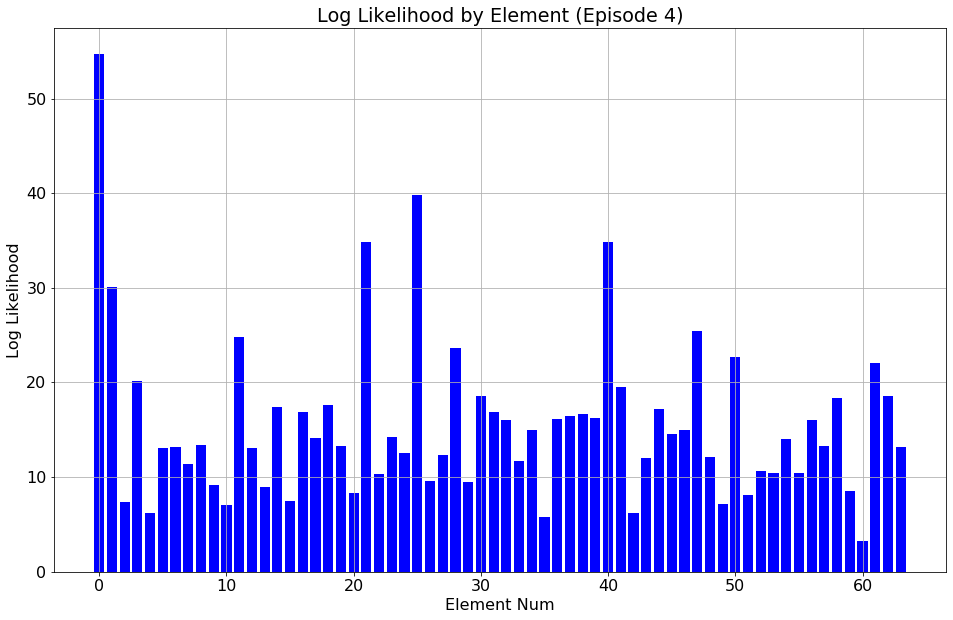

In [79]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=False)

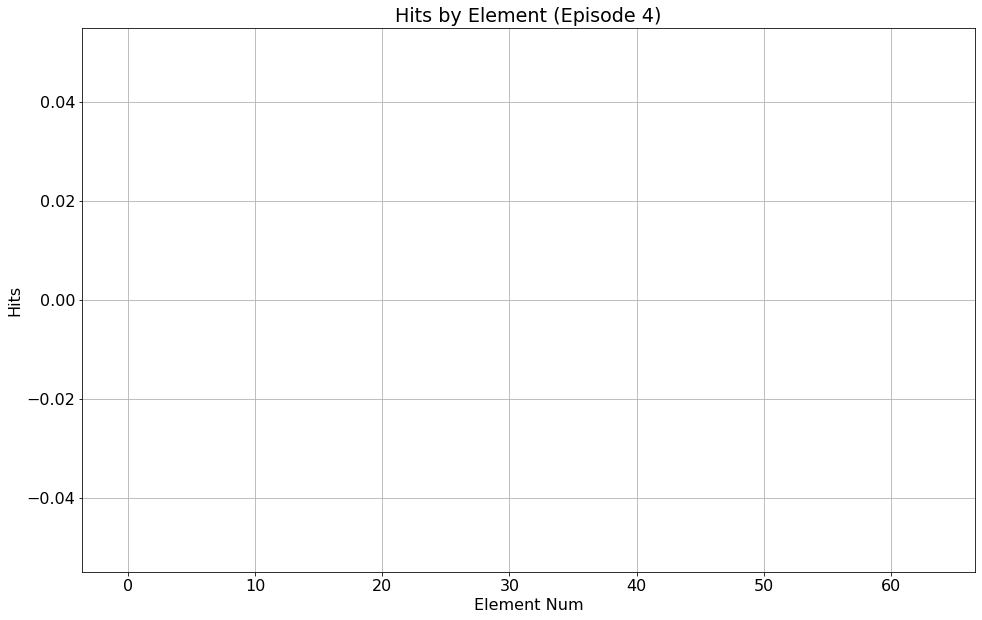

In [82]:
# Bar chart - hits
fig, ax = model.plot_bar('hits', sorted=False)

In [ ]:
# Bar chart - hits
fig, ax = model.plot_bar('R_deg', sorted=False)

In [ ]:
# Save model
# model.save_state()

In [ ]:
model.freeze_candidate_elements()

In [ ]:
# Train model in joint mode
model.search_adaptive(
    max_batches=model.current_batch+2000, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    learning_rate=learning_rate,
    reset_active_weight=True,
    verbose=verbose)

In [ ]:
model.report()

In [ ]:
model.save_state()

In [ ]:
model.thaw_score()

In [ ]:
# Train model in joint mode
model.search_adaptive(
    max_batches=model.current_batch+2000, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    learning_rate=learning_rate,
    reset_active_weight=True,
    verbose=verbose)

In [ ]:
model.report()

In [ ]:
model.save_state()

## Extended Training

In [ ]:
# # Unfreeze the score layer
# model.thaw_score()

In [ ]:
# Length of training
max_batches_element = 22000

# thresh_deg at end: 500 arc seconds
thresh_deg_end = 500 / 3600.0

# New smaller learning rate
learning_rate = 2.0**-15

# Reset active weight
reset_active_weight = True

In [ ]:
# Train model in joint mode
model.search_adaptive(
    max_batches=max_batches_element, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    thresh_deg_end=thresh_deg_end,
    learning_rate=learning_rate,
    reset_active_weight=reset_active_weight,
    verbose=verbose)

In [ ]:
model.report()

In [ ]:
# model.save_state()

In [ ]:
# Lower threshold manually
thresh_deg_score = 1.0
model.set_thresh_deg_score(thresh_deg_score)
model.freeze_score()

In [ ]:
model.search_adaptive(
    max_batches=20000, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    learning_rate=2.0**-15,
    reset_active_weight=True,
    verbose=verbose)

In [ ]:
model.report()

In [ ]:
# model.save_state()

## Review Results Graphically

In [ ]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=False)

In [ ]:
# Bar chart: hits
fig, ax = model.plot_bar('hits', sorted=False)

In [ ]:
# Bar chart: log likelihood
fig, ax = model.plot_bar('log_R', sorted=False)

In [ ]:
# # Learning curve: log likelihood
# fig, ax = model.plot_hist('log_like')

In [ ]:
# # Learning curve: hits
# fig, ax = model.plot_hist('hits')

## Distance vs. Nearest Asteroid for Fitted Elements

In [ ]:
# Find nearest asteroid to fitted elements
elts_fit, elts_near = model.nearest_ast()

In [ ]:
q_norm = elt_q_norm(elts=elts_fit, ast_num=elts_fit.nearest_ast_num)
elts_fit['nearest_ast_q_norm'] = q_norm

In [ ]:
# # Review asteroids nearest to the fitted elements
# elts_near

In [ ]:
# Review fitted elements including nearest asteroid
elts_fit

In [ ]:
# Filter for only the good ones
mask = (elts_fit.log_like > 200) & (elts_fit.R_sec < 60)
elts_fit[mask]

In [ ]:
# Filter for incomplete convergence
mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
elts_fit[mask]

## Visualize Error vs. Nearest Asteroid

In [ ]:
model.elts_near_ast

In [ ]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(is_log=True, use_near_ast_dist=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error(elt_name='a', is_log=True, elt_num=None)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error(elt_name='e', is_log=True, elt_num=None)